<a href="https://colab.research.google.com/github/felix018/project_signal/blob/main/Local_FinalProject_TS3_RadioML_2023_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

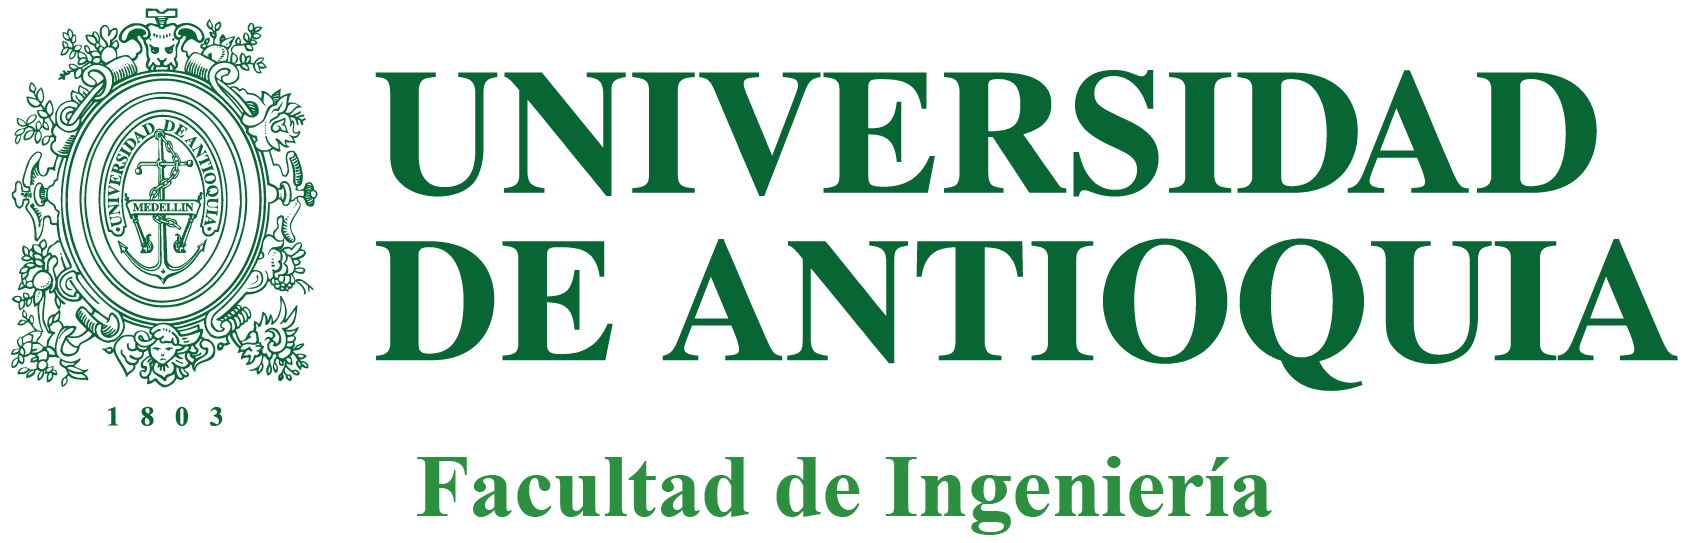
---
- **Asignatura:** Tratamiento de Señales III
- **Profesor:** Hernán Felipe García Arias
- **Ingeniería de Telecomunicaciones**
- **UdeA**
- **2023-2**

---

## Reconocimiento de modulación: conjunto de datos Radio Machine Learning 2016.10a

More information on this classification method can be found at
https://arxiv.org/abs/1602.04105

More information on the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Please cite derivative works

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

Para ejecutar este ejemplo, deberá descargar o generar el conjunto de datos RML2016.10a (https://radioml.com/datasets/)
También necesitarás Keras instalado con el backend de Theano o Tensor Flow funcionando!

In [ ]:
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:02<00:00, 248MB/s]


In [ ]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
%matplotlib inline

## Keras
[Keras](https://keras.io/) is a python abstraction which allows you to define a neural network and have it automatically coded for deep learning libraries (currently DeepLearning4j, TensorFlow, and Theano). You just tell Keras how many layers are in the network model and define what those layers look like. Keras handles converting it into something that TensorFlow and Theano can use. So it's great for rapid development experimentation with neural networks. You can quickly build things and quickly tweak neural networks.

In [ ]:
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
#from tensorflow.keras.optimizers import adam

# Dataset setup

O'Shea, Corgan, and Clancy generated a simulated data set using [GNU Radio](http://gnuradio.org). It is saved as a Pickle file. That's just a binary file that can be read into Python (it is a dictionary, similar to a JSON file).

There are other data files that you can use to train and test the model at the [radioml.com](https://radioml.com/datasets/radioml-2016-10-dataset/) website.  The Python file to create the dataset is [here](https://github.com/radioML/dataset/blob/master/generate_RML2016.10a.py).

In [ ]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

## Pickle format

The data that was saved contained one large Python dictionary array. The dictionary keys were the combinations of [modulation](https://en.wikipedia.org/wiki/Phase-shift_keying) type and signal to noise (SNR) ratios that were simulated by GNU Radio to produce the data. There are 11 modulation schemes: 8 digital and 3 analog. Gaussian white noise was added to each signal proportional to the signal's power.

For example, a [BPSK modulated](https://en.wikipedia.org/wiki/Phase-shift_keying#Binary_phase-shift_keying_.28BPSK.29) signal was simulated with SNRs of -20 dB, -18 dB, -16 dB, up to 18 dB. For a SNR of 0, the BPSK signal would have the same total power as the gaussian noise. For SNRs less than 0, the BPSK signal would be swamped by the noise. In other words, it'd be impossible for a human to identify the modulation for those SNRs.

$$ \text{SNR in decibels} = 10 \times \log \left ( \frac{\text{signal power}}{\text{noise power}} \right ) $$

In [ ]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [ ]:
print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


### Radio frequency (RF) signals

Once we've specified the dictionary key (e.g. ['QAM64', 4] for QAM64 modulation @ 4 dB SNR), then we'll be left with the following matrix.

In [ ]:
np.shape(Xd['BPSK', -18])

(1000, 2, 128)

+ The second dimension represents the two components ([I & Q](https://youtu.be/h_7d-m1ehoY)) of the RF signal.
+ The third dimension represents the 128 samples in time (1 MHz so 1 $\mu$s per index)
+ The first dimension represents the 1,000 sampled windows (each window has the 128 I & Q samples)

# Please help me correct this. I am not sure if I am calculating the raw signal correctly.

$$\text{Modulated Carrier RF} = I \cos(2\pi ft) + Q \sin(2 \pi ft)$$

In [ ]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

## Let's plot some of the raw data

So we'll just choose one 8PSK (with SNR @ 18 dB), one PAM4 (with SNR @ 6 dB), one BPSK (with SNR @ 0 dB), and one QAM64 (with SNR @ -12 dB).

Notice how the signal gets buried in the noise as the SNR decreases.

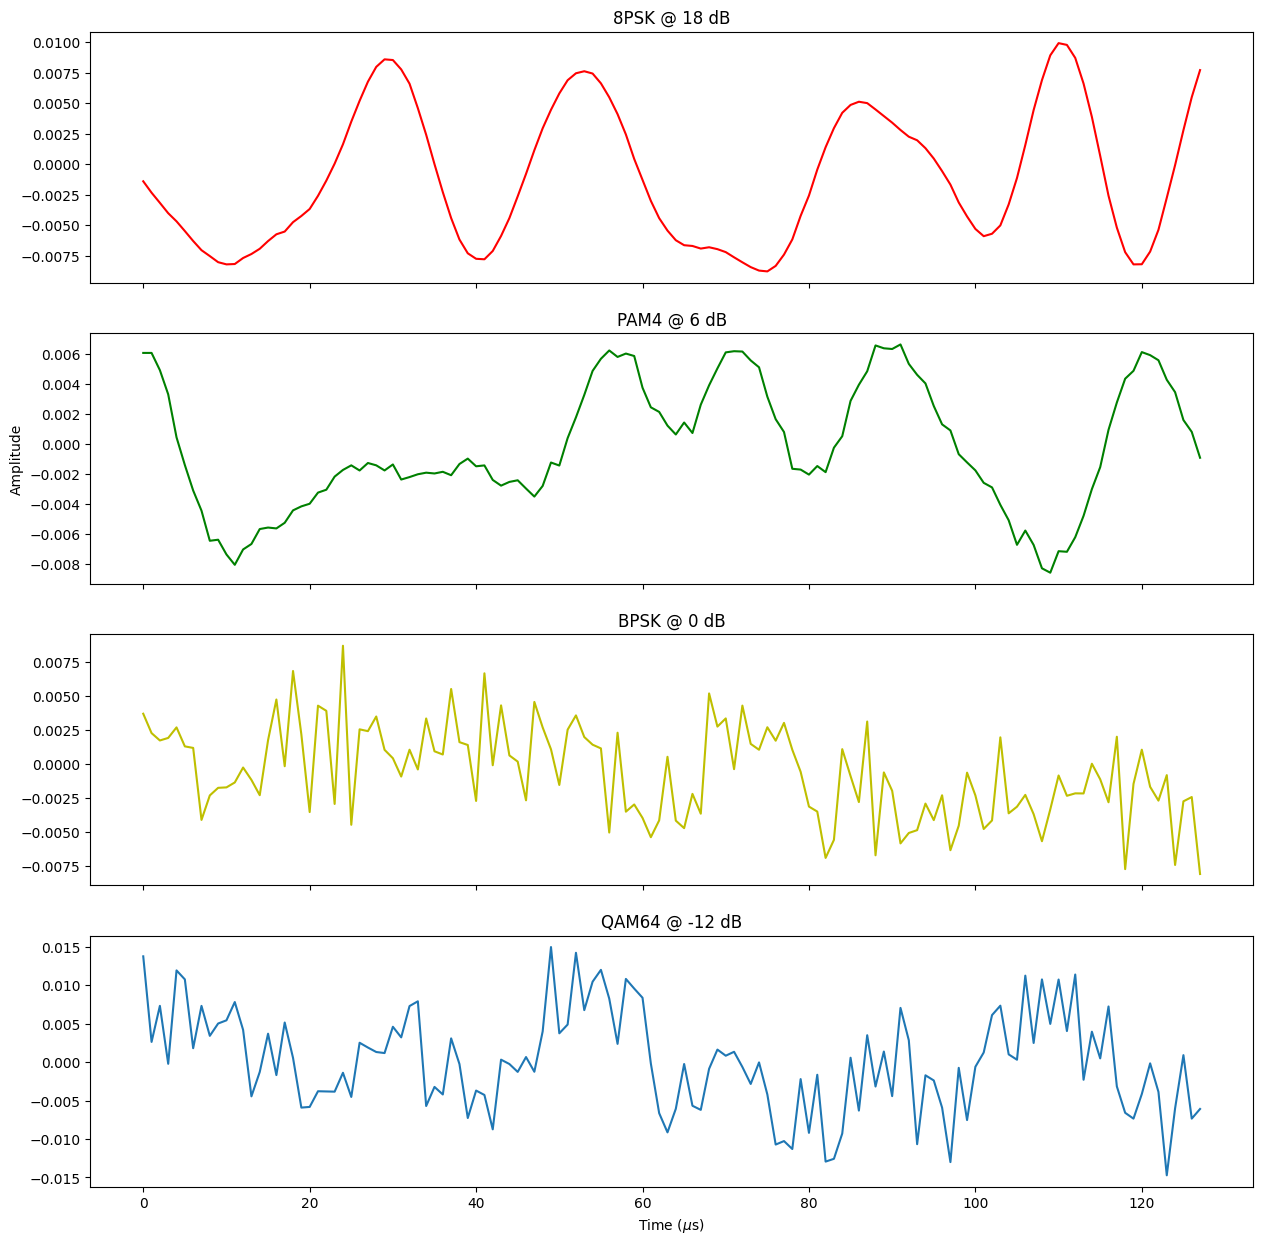

In [ ]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

## Now we need to append all of the modulation, SNR, samples, channels, and time points into one big matrix to pass into our neural net.

So there will be 220,000 samples. Each sample is 2 x 128. The 2 are the I and Q channels. The 128 are the 128 time samples of the waveform (sampled at 1 MHz).

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
np.shape(X)

(220000, 2, 128)

## Add noise class to dataset

So let's just add 2 channels of random Gaussian noise to see if we can give the network an option to pick if it can't decide between the true modulations. This is basically an "I don't know" classification.

In [ ]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

In [ ]:
print(X.shape)

(240000, 2, 128)


### Now let's randomly partition the dataset into a training group and a test group.

The training group will be used to calculate the weights for the neural network. The test group will be used to evaluate (validate) how well those weights generalize to new data (i.e. how well our neural net should perform in the wild).

Our first step is to [One Hot Encode](https://en.wikipedia.org/wiki/One-hot). It sounds bad, but is a really simple procedure. Basically, the computer doesn't understand letters; it can only use numbers. So it has no idea what '8PSK' or 'WBFM' refers to and has no way to train a model to fit those labels. Now we could just assign a number to each modulation (e.g. 1 = '8PSK', 2 = 'AM-DSB', 3 = 'PAM4', etc). However, one-hot encoding makes it easier for us to calculate how close our neural network's output (i.e. the prediction) is to the true (expected) value.

To one-hot encode we simple declare a vector that is as large as the set of unique modulations. So if we have 11 modulations, then we declare a vector of size 1 x 11. The array is 0 everywhere except for the modulation being represented. For example,

+  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
+  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
+  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
  
So the left-most element codes '8PSK' and the right-most codes 'WBFM'. The positioning is arbitrary. It just has to be consistently applied to the dataset.

Once we've One Hot encoded, we'll be able to compare how close our neural network's output (i.e. the prediction) comes to the true modulation. This "closeness" measurement is typical calculated via (Shannon) cross-entropy. There's a great [video here](https://www.youtube.com/watch?v=tRsSi_sqXjI).

$$ \text{cross entropy} = - \sum_i{L_i \log{S_i}}$$

where
+ $i$ goes from 1 to the number of modulations
+ $L_i$ is the one-hot label for that sample in that modulation
+ $S_i$ is the neural network's prediction for that sample in that modulation

For instance,  if our neural network predicts 3 classes with the following probabilities:

$$\begin{bmatrix}0.2\\0.7\\0.1 \end{bmatrix}$$

and the actual sample has the one-hot encoding of:

$$\begin{bmatrix}0\\1\\0\end{bmatrix}$$

Then our cross-entropy is:  
$$ - [ 0 \times \log(0.2) + 1 \times \log(0.7) + 0 \times \log(0.1) ] = \log(0.7) = 0.155$$

If the prediction is perfect, then the cross-entropy is $1 \times \log(1) = 0$

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lbl = np.array(lbl) # Convert from list to numpy array (for speed)

# This will encode the labels into a binary array.
# This is referred to as One-Hot.
# Each element of the array is either 1 or 0.
# The position of the element refers to which type of modulation.
# So if there are 11 modulation types, then the
# array is length 11.
# e.g.  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
#       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
#       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
# We'll use this to compare the output of the neural network
# and help train the model to give the lowest error (in this case
# the cost will be the cross-entropy).
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


In [ ]:
lbl[:10,0]

array(['8PSK', '8PSK', '8PSK', '8PSK', '8PSK', '8PSK', '8PSK', '8PSK',
       '8PSK', '8PSK'], dtype='<U21')

In [ ]:
lbl[:10,1]

array(['-20', '-20', '-20', '-20', '-20', '-20', '-20', '-20', '-20',
       '-20'], dtype='<U21')

In [ ]:
y_encoded[-10:]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

## Split into a training and testing set

It's crucial that we split the data into at least 2 sets. One set (called the training set) will be used to train the neural network. That is, the weights of the neural network will be adjusted to make the best possible prediction of the training data. However, if we just stopped there, then we'd have a model that was good at predicting things it already knew the answers to. We want to ensure that the model can predict things it has never seen before. So we save some data (usually about 1/4 to 1/3) to test whether the trained neural network can be just as accurate on data it has never seen.

Most decent machine learning toolkits contain a method to randomly split your data into these two sets. We typically use the one from sklearn (train_test_split). However, we want to keep track of the indices so that we can also get the SNRs at the end. So we'll just use a random array to split the two groups.

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [ ]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (168000, 2, 128)
Test set is (72000, 2, 128)


In [ ]:
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print(X_train.shape, in_shp)
classes = mods
print(classes)

(168000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


# Build the NN Model

Your task here is to code 2 CNN architectures to assess modulation recognition using Deep Learning Approaches

In [ ]:
# Reshape input data from (2, 128) to (2, 128, 1)
X_train = X_train.reshape(X_train.shape[0], 2, 128, 1)
X_test = X_test.reshape(X_test.shape[0], 2, 128, 1)

In [ ]:
# Build CNN Neural Net model using tensorflow  --
#  - Reshape [N,2,128] to [N,2,128,1] on input
#  - Pass through 3 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()  # Neural network is a set of sequential layers
#model.add(Convolution2D(...))
model.add(Convolution2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(2,128,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Convolution2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

# Take a look at the model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 2, 128, 64)        320       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 1, 64, 64)         0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 1, 64, 64)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 1, 64, 32)         8224      
                                                                 
 dropout_17 (Dropout)        (None, 1, 64, 32)         0         
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                      

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

For the model training, please use `ModelCheckpoint` and `EarlyStopping` to monitor training and avoid overfitting

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/100

Epoch 1: val_loss improved from inf to 2.07158, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 2.2266 - accuracy: 0.2020 - val_loss: 2.0716 - val_accuracy: 0.2326 - 4s/epoch - 27ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 2.07158 to 1.93923, saving model to ./PESOS_TSIII.wts.h5
165/165 - 3s - loss: 1.9962 - accuracy: 0.2725 - val_loss: 1.9392 - val_accuracy: 0.3012 - 3s/epoch - 15ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.93923 to 1.87581, saving model to ./PESOS_TSIII.wts.h5
165/165 - 2s - loss: 1.9312 - accuracy: 0.2990 - val_loss: 1.8758 - val_accuracy: 0.3136 - 2s/epoch - 15ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.87581 to 1.77832, saving model to ./PESOS_TSIII.wts.h5
165/165 - 2s - loss: 1.8565 - accuracy: 0.3162 - val_loss: 1.7783 - val_accuracy: 0.3353 - 2s/epoch - 15ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.77832 to 1.73181, saving model to ./PESOS_TSIII.wts.h5
165/165 - 2s - loss: 1.7751 - accuracy: 0.3380 - val_loss: 1.7318 - val_accuracy: 0.3515 - 2s/epoch - 15ms/step
Epoch 6/100

Epoch 6: val_loss improved from 1.73181 to 1.64728, saving model to ./PESOS_TSIII.wts.h5
165/165 - 3s - loss: 1.7156 - accuracy: 0.3622 - val_l

In [ ]:
# Evaluate the model on test set
score = model.evaluate(X_test, Y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.5681388974189758


# Evaluate and Plot Model Performance

In [ ]:
from sklearn.metrics import classification_report
y_predict = np.argmax(model.predict(X_test),axis=-1)
print(classification_report(np.argmax(Y_test, axis=1), y_predict))

2250/2250 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      5957
           1       0.53      0.67      0.59      5852
           2       0.26      0.88      0.41      5932
           3       0.84      0.57      0.68      6051
           4       0.78      0.58      0.67      5963
           5       0.75      0.60      0.67      6022
           6       1.00      1.00      1.00      6125
           7       0.92      0.65      0.76      5991
           8       0.40      0.29      0.33      5906
           9       0.53      0.47      0.49      6029
          10       0.70      0.41      0.51      6072
          11       0.60      0.20      0.30      6100

    accuracy                           0.57     72000
   macro avg       0.65      0.57      0.58     72000
weighted avg       0.65      0.57      0.58     72000



## Loss curves

Loss curves show us how well the training went. They also allow us to detect over-training of the model. If the model is over-trained, then it might not generalize well. Often, in an over-trained model, the training loss (error) will continually decrease while the validation (test error) will decrease and then begin to increase again with successive training epochs.

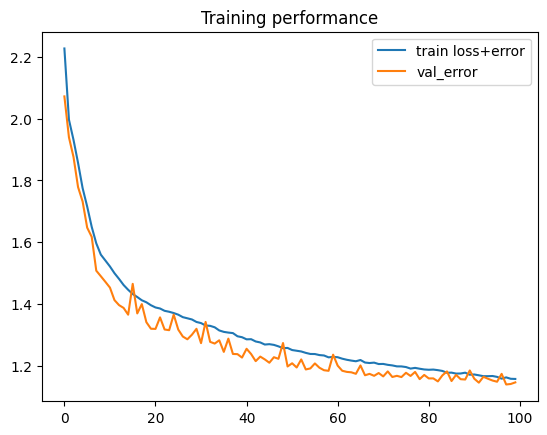

In [ ]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

# Confusion Matrix

A confusion matrix is a great way to see where the model (neural network) had trouble. It plots the number of times the model predicted a modulation versus the actual modulation (predicted versus true).

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

71/71 [==============================] - 0s 4ms/step


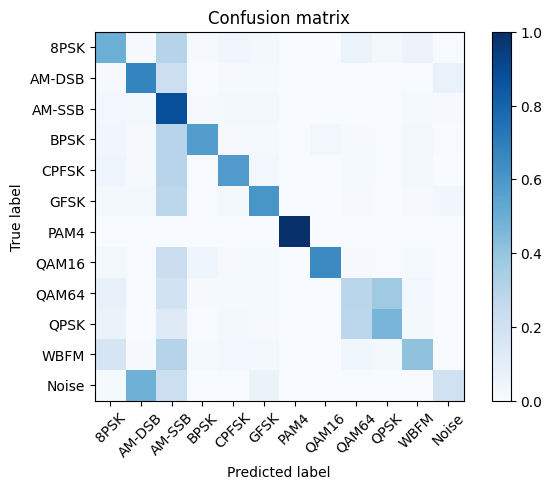

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Pleaes evaluate the model in terms of $SNR$ and their accuracy for each modulation (below is a a sample code to assess your models)

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

  # extract classes @ SNR
  test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
  test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
  test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]
  # estimate classes
  test_Y_i_hat = model.predict(test_X_i)
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])
  for i in range(0,test_X_i.shape[0]):
      j = list(test_Y_i[i,:]).index(1)
      k = int(np.argmax(test_Y_i_hat[i,:]))
      conf[j,k] = conf[j,k] + 1
  for i in range(0,len(classes)):
      confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
  plt.figure()
  plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
  acc[snr] = 1.0*cor/(cor+ncor)


In [ ]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs));
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");

## Final Project Assignment: Modulation Recognition Using Convolutional Neural Networks (CNN) with Database


**Objective:**
- The objective of this final project is to design and implement a modulation recognition system using Convolutional Neural Networks (CNN). The project will involve building a robust CNN model capable of accurately classifying different modulation schemes present in the provided database (RadioML2016). Modulation recognition is a crucial task in wireless communication systems, and your implementation will contribute to the advancement of signal processing in communications.

**Dataset:**
- You will be provided with a dataset (Database RadioML2016) containing samples of signals with various modulation schemes. The dataset is divided into training and testing sets. It is essential to preprocess the data appropriately to feed it into the CNN model.

**Tasks:**

1. Data Preprocessing: Load and explore the dataset to understand its structure and characteristics.
Preprocess the data, including normalization, resizing, and any other necessary steps to prepare it for input into the CNN.
2. CNN Model Architecture:
Design a CNN architecture suitable for modulation recognition. Consider the input shape, number of layers, filter sizes, and activation functions.
Implement the CNN model using a deep learning framework of your choice (e.g., TensorFlow, PyTorch, Keras).
3. Training: Split the dataset into training and validation sets.
Train the CNN model using the training set, monitoring and optimizing for performance on the validation set.
Experiment with different hyperparameters to enhance the model's accuracy.
4. Evaluation: Evaluate the trained model on the testing set to assess its performance in recognizing modulation schemes.
Calculate relevant metrics such as accuracy, precision, recall, and F1 score.
5. Analysis and Visualization: Provide visualizations of the training/validation loss and accuracy over epochs.
Analyze the confusion matrix to understand the model's performance on different modulation schemes.
6. Documentation: Prepare a comprehensive notebook report documenting the entire project, including data exploration, model architecture, training process, evaluation results, and analysis. Include code documentation and comments for clarity.
7. Presentation: Prepare a pitch presentation summarizing key aspects of your project.
Present the motivation, methodology, results, and any challenges faced during the implementation.
8. Submission Guidelines: Submit the project code along with a README file providing instructions on how to run the code (use GIT).
9. Submit the project report in a clear and organized format on GIT repo.
10. Ensure that your implementation is well-documented, and your code follows best practices.


*This final project will not only test your understanding of modulation recognition and CNNs but also your ability to apply machine learning concepts to real-world signal processing challenges.*

Good luck!







-